# Подсказчик судоку

Сделал простенькую модель, которая по загруженной картинке подскажет решение судоку. Скрипт для решения игры у меня есть, но нужно уметь разобрать картинку, вытащить из неё цифры.

Как итог - пришлось крепко помучиться с *тессерактом*  (нейросеткой, распознающей цифры). Потому как нужно было почистить доску от малых цифр-подсказок. И разгадывает он цифры совсем не так хорошо как хотелось бы. Подбор гиперпараметров - наше всё.

Скрипт для решения игры писан сто лет назад, и не отличается особым качеством. Пришлось минимально адаптировать под работу с numpy. Содержит массу некрасивостей (и даже глупостей) в коде. Впрочем, как всякий старый код.

In [1]:
#Установки в среде
!pip install pytesseract

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract

In [3]:
TESSERACT_CONFIG = '--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'

actual_matrix = np.array([[3, 2, 0, 0, 0, 4, 1, 0, 8],
       [0, 4, 0, 8, 0, 0, 0, 5, 0],
       [5, 8, 9, 3, 1, 7, 2, 0, 0],
       [0, 5, 2, 4, 0, 3, 0, 1, 0],
       [0, 7, 0, 2, 6, 5, 0, 0, 0],
       [0, 3, 0, 1, 0, 9, 5, 0, 2],
       [8, 9, 4, 7, 3, 1, 6, 2, 5],
       [2, 6, 5, 9, 4, 8, 7, 3, 1],
       [7, 1, 3, 0, 0, 0, 0, 0, 9]])

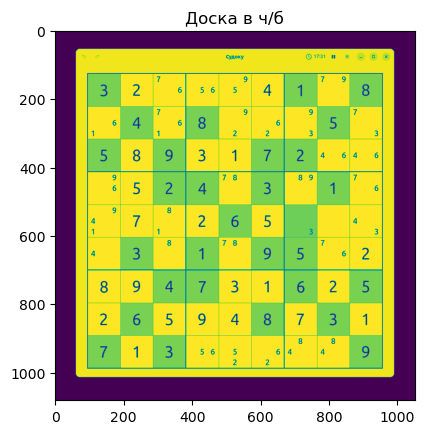

In [4]:
image = cv2.imread('img/sudoku-1.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(image)
plt.title('Доска в ч/б')
plt.show()

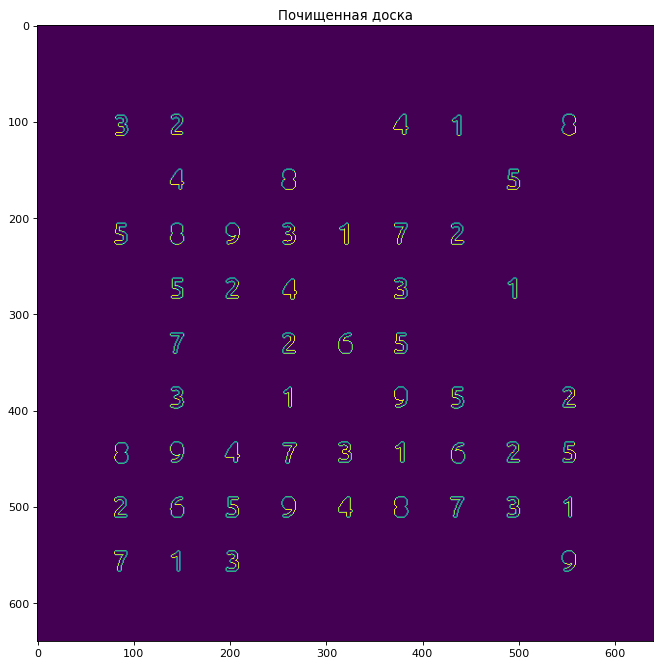

In [5]:
def contour_height(contour):
    points = contour.squeeze()
    return max(points[:, 1]) - min(points[:, 1])

resized_img_size = 640

resized = cv2.resize(image, (resized_img_size,resized_img_size))
_, thresh_img = cv2.threshold(resized, 35, 255, cv2.THRESH_BINARY)

kernel_size = 2  # Размер ядра (радиус фильтра)
kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
dilated = cv2.erode(thresh_img, kernel)

contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
min_height = 12
max_height = 30

filtered_contours = [cnt for cnt in contours if max_height >= contour_height(cnt) >= min_height]
img_contours = np.uint8(np.zeros((thresh_img.shape[0],thresh_img.shape[1])))
cv2.drawContours(img_contours, filtered_contours, -1, (255,255,255), 1)



plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img_contours)

plt.title('Почищенная доска')
plt.show()
#list(map(contour_height, contours))

#### Распознаём циферки

Точнее учимся распознавать. Потом распознавалку нужно вытащить в отдельную функцию, которая ничего не должна знать об оригинальной матрице.
Подбор параметров (прежде всего размерностей) для того, чтобы тессеракт корректно распознал все цифры оказался весьма трудоёмким делом.
Финальный штрих - это расширение окна на 1 по y влево. Оно сразу улучшило распознавание. Вот кто-бы знал.

Возможно стоило запариться и взять другую сетку для распознавания цифр, было бы проще.

[[3 2 0 0 0 4 1 0 0]
 [0 4 0 8 0 0 0 5 0]
 [5 8 9 3 1 7 2 0 0]
 [0 5 2 4 0 3 0 1 0]
 [0 7 0 2 6 5 0 0 0]
 [0 3 0 1 0 9 5 0 2]
 [0 9 4 7 3 1 6 2 5]
 [2 6 5 9 4 8 7 3 1]
 [7 1 3 0 0 0 0 0 9]]


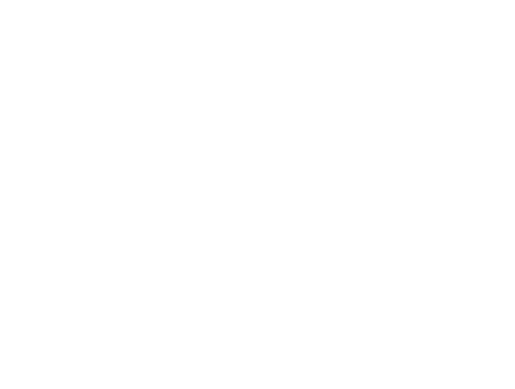

In [6]:
#Преобразование координат из рисунка в итоговую матрицу
xes = list(map(lambda a: cv2.boundingRect(a)[0], filtered_contours))
yes = list(map(lambda a: cv2.boundingRect(a)[1], filtered_contours))
divisor_x = (max(xes) - min(xes)) // 8
divisor_y = (max(yes) - min(yes)) // 8

#Создаём итоговую матрицу
matrix = np.zeros((9,9), np.byte)

# Рисуем ошибки. Это нужно будет убрать, когда делать скрипт
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1, ax2, ax3, ax4]
for ax in axes:
    ax.axis('off')
imcount = 0    

for i, cnt in enumerate(filtered_contours):
    x, y, w, h = cv2.boundingRect(cnt)
    digit_roi = resized[y-1:y + h, x:x + w]
    dilated_roi = dilated[y-1:y + h, x:x + w]
    digit_text_o = pytesseract.image_to_string(digit_roi, config=TESSERACT_CONFIG)
    digit_text_d = pytesseract.image_to_string(dilated_roi, config=TESSERACT_CONFIG)
    dilated_txt = digit_text_d.strip()
    digit_text = dilated_txt if dilated_txt == "" else digit_text_o
    m_x = x // divisor_x - 1
    m_y = y // divisor_y - 1
    if digit_text.strip():
         matrix[m_y][m_x] = digit_text.strip()
         if (matrix[m_y][m_x] != actual_matrix[m_y][m_x]):
             print(f"Ошибка: ({m_y}, {m_x}), real={actual_matrix[m_y][m_x]} wrong={matrix[m_y][m_x]} dilated={dilated_txt} shape={dilated_roi.shape}")
             axes[imcount].imshow(digit_roi)
             axes[imcount].set_title(f"Реальное {digit_text_o.strip()} ({actual_matrix[m_y][m_x]})")
             axes[imcount + 1].imshow(dilated_roi)
             axes[imcount + 1].set_title(f"Расширенное {dilated_txt} ({actual_matrix[m_y][m_x]})")
             imcount += 2
print(matrix)
if imcount != 0:
    plt.show()

### Решаем полученную матрицу-судоку

Я когда-то уже делал подобную штуку, так что возьму старый код и заставлю выдавать только одну подсказку, а не полное решение.
Ну и как всегда для старого кода слегка приведу в порядок.

In [7]:
def is_same_square(cell1, cell2):
    return cell1[0] // 3 == cell2[0] // 3 and cell1[1] // 3 == cell2[1] // 3

def is_same(cell1, cell2):
    return cell1[0] == cell2[0] and cell1[1] == cell2[1]    

def condition_exclude(exclude):    
    def cond(cell):
        return not reduce(lambda o,b: o or is_same(cell,b), exclude, False)
    return cond    

def key(el):
    return int(reduce(lambda o,a: o + str(a), el[2], ''))

class BadSetError(Exception):
    pass

full_set = set([1,2,3,4,5,6,7,8,9])
cell_keys = ((0,0), (3,0), (6,0), (0,3), (3,3), (6,3), (0,6), (3,6), (6,6))

class SudokuSolver:

    cell_size = 3

    def __init__(self, field, prefix='', verbose=1):
        self.field = field
        self.moves = []
        self.free = []
        self.prefix = prefix
        self.stage = ''
        self.verbose = verbose


    def solve(self):
        self._fill()
        try:
            while (self._solve_by_absent() + self._solve_by_present() + self._solve_by_square_rows() > 0):
                pass
            if self.solved(): 
                print(self.prefix + "Решено!")    
            else:
                susp = ()
                for k in self.free:
                    if len(k[2]) == 2:
                        susp = k
                        break
                print(self.prefix + 'Облом, не хватает методов, гадаю.')
                for k in list(susp[2]):
                    print(self.prefix + "Пробую вариант %d для %s" % (k, susp))
                    new_field = copy.deepcopy(self.field)
                    new_field[susp[0]][susp[1]] = k
                    s = SudokuSolver(new_field, prefix="\t" + self.prefix)
                    if s.solve():
                        return True
                return False        
        except BadSetError as e:
            print(self.prefix + "Oops", e)        
            return False
        for f in self.field:
            print(f)    
        return True    

    def solved(self):
        return len(self.free) == 0    


    def _get_square_data(self, cell):
        struct = {}
        for field in self.free:
            if is_same_square(field, cell):
                for k in field[2]:
                    try:
                        struct[k].append((field[0], field[1]))
                    except KeyError:
                        struct[k]= [(field[0], field[1])]
        return struct                    


    def _solve_by_absent(self):    
        self.stage = 'Единственный вариант'
        ch = 0
        for cell in self.free:
            if len(cell[2]) == 1:
                val = list(cell[2])[0]
                self.field[cell[0]][cell[1]] = val
                self._set_number(cell[0], cell[1], val)
                ch += 1
        return ch        

    def _solve_by_present(self):
        self.stage = 'Один в блоке'
        ch = 0
        for cell in cell_keys:
            data = self._get_square_data(cell)
            for d in data:
                if len(data[d]) == 1:
                    self.field[data[d][0][0]][data[d][0][1]] = d
                    self._set_number(data[d][0][0], data[d][0][1], d)    
                    ch += 1
        return ch            

    def _solve_by_square_rows(self):
        changes = 0
        def has_same_row(val, el):
            try:
                return el if val == None or el[0] == val[0] else False
            except:
                return False

        def has_same_col(val, el):
            try:
                return el if val == None or el[1] == val[1] else False
            except:
                return False
        for c in cell_keys:
            struct = self._get_square_data(c)
            for value in struct:
                if r := reduce(has_same_col, struct[value]):
                    changes += self._clear_row((r[0], r[1], set([value])), lambda a: not is_same_square(r, a))
                if r := reduce(has_same_row, struct[value]):
                    changes += self._clear_col((r[0], r[1], set([value])), lambda a: not is_same_square(r, a))
        if changes and self.verbose>0:            
            print(self.prefix + '...Оптимизаций: %d' % changes)
        return changes    


    def _set_number(self, i, j, val):
        def unset_num(tg):
            if tg[0] == i or tg[1] == j or (i // 3 == tg[0] // 3 and j // 3 == tg[1] // 3):
                try:
                    tg[2].remove(val)
                    if (len(tg[2]) == 0 and not is_same(tg, (i,j))):
                        raise BadSetError("Setting (%d,%d) to %d empties (%s)." % (i,j,val,tg))
                except KeyError:
                    pass        
            return tg
        self.free = list(filter(lambda a: a[0] != i or a[1] !=j, map(unset_num, self.free))) 
        for k in  range(9):
            for l in range(9):
                if self.field[k][l] == val and not is_same((i,j), (k,l)) and (i==k or j==l or is_same_square((i,j), (k,l))):
                    raise BadSetError("Setting (%d,%d) to %d blocked by (%d,%d)." % (i,j,val,k,l))
        print(self.prefix + self.stage + " [%d, %d] = %d" % (i + 1, j + 1, val))
           

    def _sqare2array(self, i, j):
        si = i // 3 * 3
        sj = j // 3 * 3 
        res = []
        i = 0
        for k in range(si, si+3):
            for l in range(sj, sj+3):
                res.append(self.field[k][l])
        return res

    def _column(self, j):
        res = []
        for k in range(9):
            res.append(self.field[k][j])
        return res   

    def _can_set(self, i, j):    
        presence = set(list(self.field[i]) + list(self.field[:,j]) + self._sqare2array(i,j))  
        return full_set - presence

    def _fill(self):
        for i in range(9):
            for j in range(9):
                if self.field[i][j] == 0:
                    self.free.append((i, j, self._can_set(i,j)))           

    def _clear_row(self, sample, condition):                
        changed = 0
        for k in range(len(self.free)):
            cell = self.free[k]
            if (cell[1] == sample[1] and condition(cell)):
                if len(cell[2].intersection(sample[2])):
                    self.free[k] = (self.free[k][0], self.free[k][1], cell[2] - sample[2])
                    if self.verbose > 1:
                        print(self.prefix + "Changed row pair", cell, '=>', self.free[k])
                    changed += 1    
        return changed            

    def _clear_col(self, sample, condition):                
        changed = 0
        for k in range(len(self.free)):
            cell = self.free[k]
            if (cell[0] == sample[0] and condition(cell)):
                if len(cell[2].intersection(sample[2])):
                    self.free[k] = (self.free[k][0], self.free[k][1], cell[2] - sample[2])
                    if len(self.free[k][2]) == 0:
                        raise BadSetError("Error clearing col (%d,%d) on %d " % sample)
                    if self.verbose > 1:
                        print(self.prefix + "Changed col", cell, '=>', self.free[k])
                    changed += 1
        return changed       

In [8]:
from functools import reduce
import copy
s = SudokuSolver(matrix.copy())
s.solve()
matrix


Единственный вариант [7, 1] = 8
Облом, не хватает методов, гадаю.
Пробую вариант 6 для (0, 2, {6, 7})
	Единственный вариант [1, 4] = 5
	Единственный вариант [1, 5] = 9
	Единственный вариант [2, 1] = 1
	Единственный вариант [2, 3] = 7
	Единственный вариант [2, 5] = 2
	Единственный вариант [2, 6] = 6
	Единственный вариант [2, 9] = 3
	Единственный вариант [6, 3] = 8
	Единственный вариант [6, 5] = 7
	Единственный вариант [9, 4] = 6
	Единственный вариант [9, 5] = 5
	Единственный вариант [9, 6] = 2
	Один в блоке [5, 3] = 1
	Один в блоке [4, 5] = 8
	Oops Setting (1,6) to 9 empties ((3, 6, set())).
Пробую вариант 7 для (0, 2, {6, 7})
	Один в блоке [2, 9] = 7
	Один в блоке [6, 8] = 7
	...Оптимизаций: 8
	Единственный вариант [1, 9] = 8
	Единственный вариант [2, 6] = 2
	Единственный вариант [3, 9] = 4
	Единственный вариант [4, 1] = 9
	Единственный вариант [4, 7] = 8
	Единственный вариант [4, 9] = 6
	Единственный вариант [5, 1] = 1
	Единственный вариант [5, 3] = 8
	Единственный вариант [5, 9] = 3


array([[3, 2, 0, 0, 0, 4, 1, 0, 0],
       [0, 4, 0, 8, 0, 0, 0, 5, 0],
       [5, 8, 9, 3, 1, 7, 2, 0, 0],
       [0, 5, 2, 4, 0, 3, 0, 1, 0],
       [0, 7, 0, 2, 6, 5, 0, 0, 0],
       [0, 3, 0, 1, 0, 9, 5, 0, 2],
       [0, 9, 4, 7, 3, 1, 6, 2, 5],
       [2, 6, 5, 9, 4, 8, 7, 3, 1],
       [7, 1, 3, 0, 0, 0, 0, 0, 9]], dtype=int8)